In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import sys

sys.path.insert(0, '..')
from src.rsa import compare_rsa

/home/snail-race/projects/snail-ssl/envs/env/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


number of Cux2-CreERT2 experiment containers: 8



2024-06-18 00:10:28,294 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514429113


experiment container: 511510736; num experiments: 1


2024-06-18 00:11:18,545 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721211


there are 174 neurons in this session


2024-06-18 00:11:46,291 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516802668


experiment container: 511510855; num experiments: 1


2024-06-18 00:12:45,492 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721364


there are 242 neurons in this session


2024-06-18 00:13:16,555 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514408643


experiment container: 511509529; num experiments: 1


2024-06-18 00:13:57,364 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721202


there are 214 neurons in this session


2024-06-18 00:14:26,020 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514430242


experiment container: 511507650; num experiments: 1


2024-06-18 00:14:55,880 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721219


there are 152 neurons in this session


2024-06-18 00:15:19,878 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514376818


experiment container: 511510650; num experiments: 1


2024-06-18 00:15:56,617 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721226


there are 163 neurons in this session


2024-06-18 00:16:20,370 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/704855394


experiment container: 701412138; num experiments: 1


2024-06-18 00:16:48,738 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722679


there are 120 neurons in this session


2024-06-18 00:17:06,679 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516470788


experiment container: 511510718; num experiments: 1


2024-06-18 00:18:17,371 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721348


there are 331 neurons in this session


2024-06-18 00:18:59,920 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514684659


experiment container: 511510670; num experiments: 1


2024-06-18 00:19:54,460 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721238


there are 295 neurons in this session
Calculating RDMs for ../models/rat1.ckpt


2024-06-18 00:20:34,407 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514422179


Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



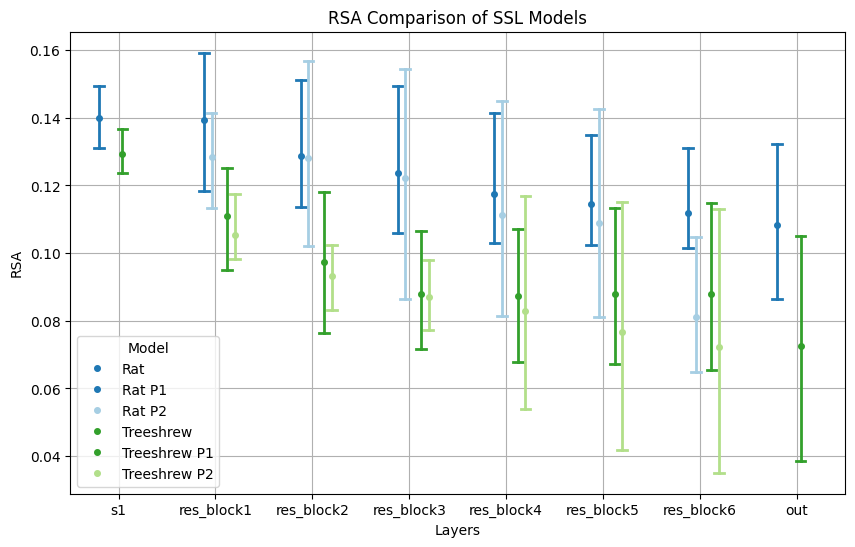

number of Cux2-CreERT2 experiment containers: 8



2024-06-18 00:21:56,816 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/703325013


experiment container: 702934962; num experiments: 1


2024-06-18 00:22:22,334 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722673


there are 118 neurons in this session


2024-06-18 00:22:41,554 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/645883993


experiment container: 645413757; num experiments: 1


2024-06-18 00:23:28,539 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722239


there are 206 neurons in this session


2024-06-18 00:23:57,618 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/660075449


experiment container: 659767480; num experiments: 1


2024-06-18 00:24:25,819 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722433


there are 143 neurons in this session


2024-06-18 00:24:45,112 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/712942511


experiment container: 712178509; num experiments: 1


2024-06-18 00:25:22,266 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722714


there are 159 neurons in this session


2024-06-18 00:25:46,444 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721210


experiment container: 511510667; num experiments: 1
there are 212 neurons in this session


2024-06-18 00:26:33,052 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/526515309


experiment container: 524691282; num experiments: 1


2024-06-18 00:27:33,994 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721395


there are 249 neurons in this session


2024-06-18 00:28:08,261 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516965999


experiment container: 511510699; num experiments: 1


2024-06-18 00:29:02,359 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721251


there are 287 neurons in this session


2024-06-18 00:29:42,487 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516803372


experiment container: 511510779; num experiments: 1


2024-06-18 00:30:54,163 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721254


there are 359 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



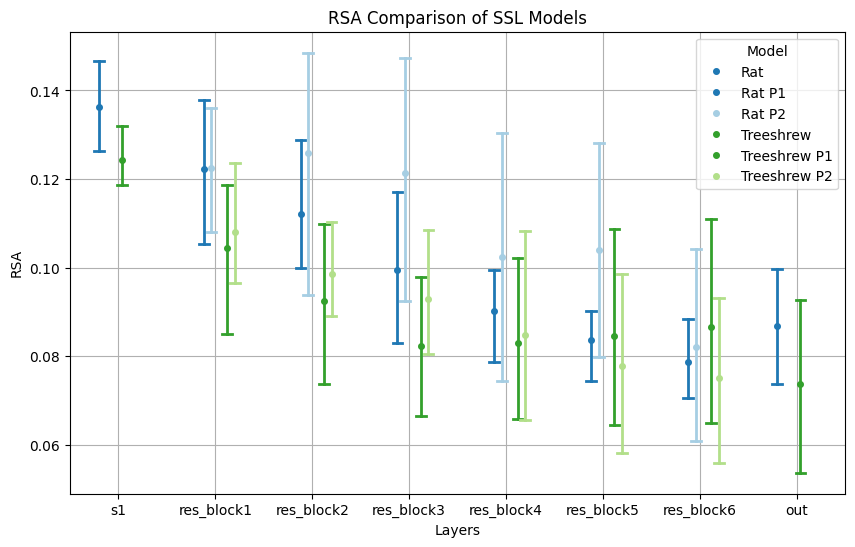

number of Cux2-CreERT2 experiment containers: 6



2024-06-18 00:32:33,452 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243940


experiment container: 511510994; num experiments: 1


2024-06-18 00:33:04,445 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721287


there are 99 neurons in this session


2024-06-18 00:33:19,272 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/649334201


experiment container: 647595663; num experiments: 1


2024-06-18 00:33:48,864 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/740369589


there are 114 neurons in this session


2024-06-18 00:34:03,064 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516804280


experiment container: 511510917; num experiments: 1


2024-06-18 00:34:35,392 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721301


there are 176 neurons in this session


2024-06-18 00:35:01,048 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516802878


experiment container: 511510688; num experiments: 1


2024-06-18 00:35:31,285 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721220


there are 137 neurons in this session


2024-06-18 00:35:51,825 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514681679


experiment container: 511510640; num experiments: 1


2024-06-18 00:36:27,344 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721243


there are 175 neurons in this session


2024-06-18 00:36:49,337 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/552520251


experiment container: 551657958; num experiments: 1


2024-06-18 00:37:10,980 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721481


there are 74 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



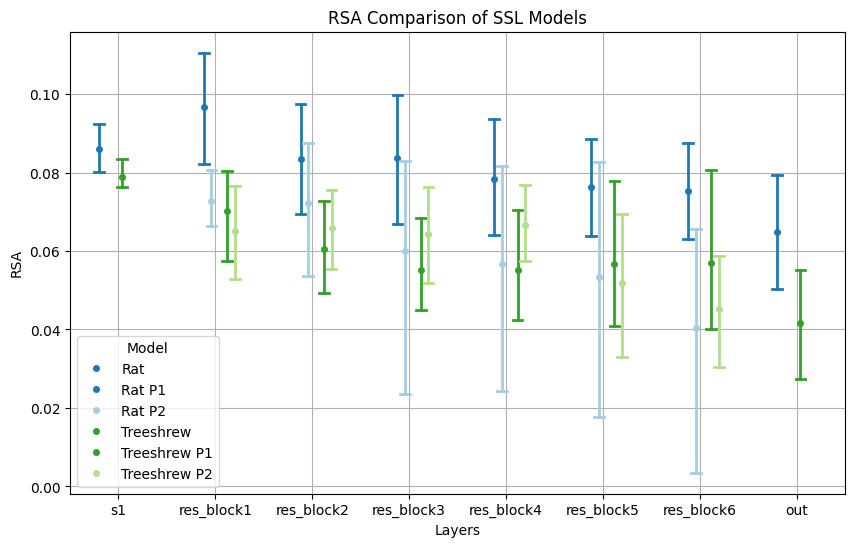

number of Cux2-CreERT2 experiment containers: 5



2024-06-18 00:38:08,385 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/699857779


experiment container: 699155263; num experiments: 1


2024-06-18 00:38:53,062 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722666


there are 125 neurons in this session


2024-06-18 00:39:12,187 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516445696


experiment container: 511510870; num experiments: 1


2024-06-18 00:40:15,767 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721337


there are 257 neurons in this session


2024-06-18 00:40:47,709 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/530476977


experiment container: 529487170; num experiments: 1


2024-06-18 00:41:20,555 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721412


there are 147 neurons in this session


2024-06-18 00:41:39,805 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517032431


experiment container: 511510848; num experiments: 1


2024-06-18 00:42:42,419 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721319


there are 297 neurons in this session


2024-06-18 00:43:21,463 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516968110


experiment container: 511510945; num experiments: 1


2024-06-18 00:44:11,691 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721318


there are 243 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



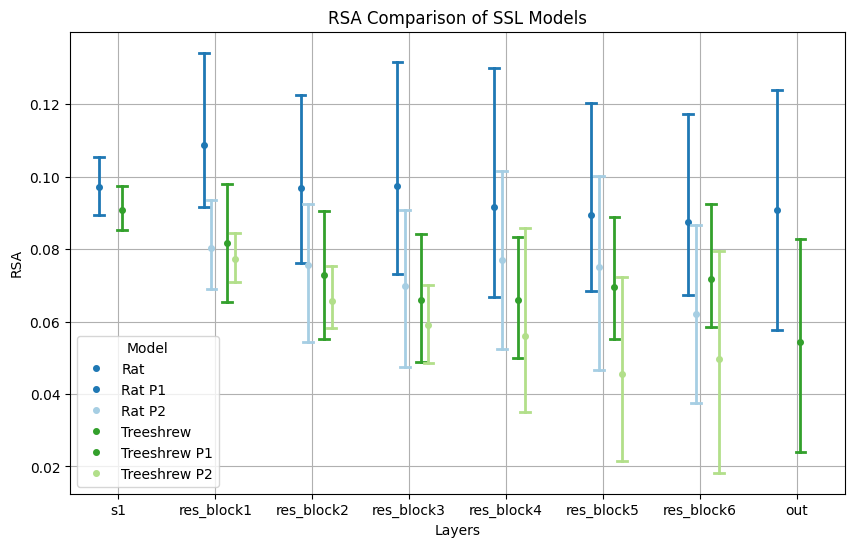

number of Cux2-CreERT2 experiment containers: 6



2024-06-18 00:45:32,526 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516246170


experiment container: 511510715; num experiments: 1


2024-06-18 00:46:11,290 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721228


there are 172 neurons in this session


2024-06-18 00:46:41,076 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243736


experiment container: 511510998; num experiments: 1


2024-06-18 00:47:10,356 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721293


there are 89 neurons in this session


2024-06-18 00:47:27,245 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514549621


experiment container: 511510797; num experiments: 1


2024-06-18 00:48:06,831 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721227


there are 164 neurons in this session


2024-06-18 00:48:30,204 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514383985


experiment container: 511510695; num experiments: 1


2024-06-18 00:48:53,422 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721261


there are 89 neurons in this session


2024-06-18 00:49:05,834 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557934565


experiment container: 555700037; num experiments: 1


2024-06-18 00:49:32,278 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721512


there are 78 neurons in this session


2024-06-18 00:49:43,324 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514798760


experiment container: 511510664; num experiments: 1


2024-06-18 00:50:18,117 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721240


there are 161 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



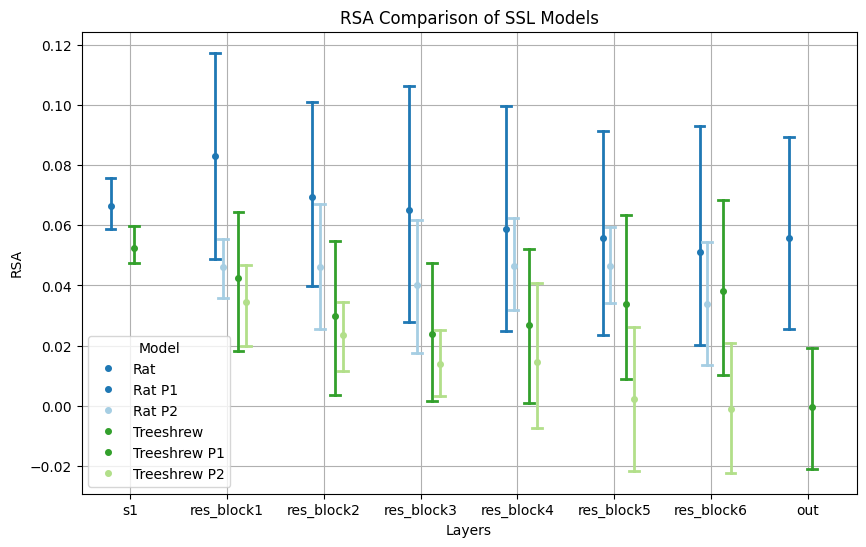

number of Cux2-CreERT2 experiment containers: 6



2024-06-18 00:51:32,204 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516803585


experiment container: 511854338; num experiments: 1


2024-06-18 00:52:01,922 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721388


there are 169 neurons in this session


2024-06-18 00:52:30,151 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243715


experiment container: 511510867; num experiments: 1


2024-06-18 00:53:02,875 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721271


there are 155 neurons in this session


2024-06-18 00:53:26,267 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516251550


experiment container: 511511052; num experiments: 1


2024-06-18 00:53:58,445 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721316


there are 171 neurons in this session


2024-06-18 00:54:18,984 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557957516


experiment container: 556936291; num experiments: 1


2024-06-18 00:54:55,115 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721533


there are 173 neurons in this session


2024-06-18 00:55:18,046 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516346761


experiment container: 511856567; num experiments: 1


2024-06-18 00:56:01,659 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721384


there are 195 neurons in this session


2024-06-18 00:56:25,624 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/636948825


experiment container: 638056632; num experiments: 1


2024-06-18 00:57:02,493 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722139


there are 146 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



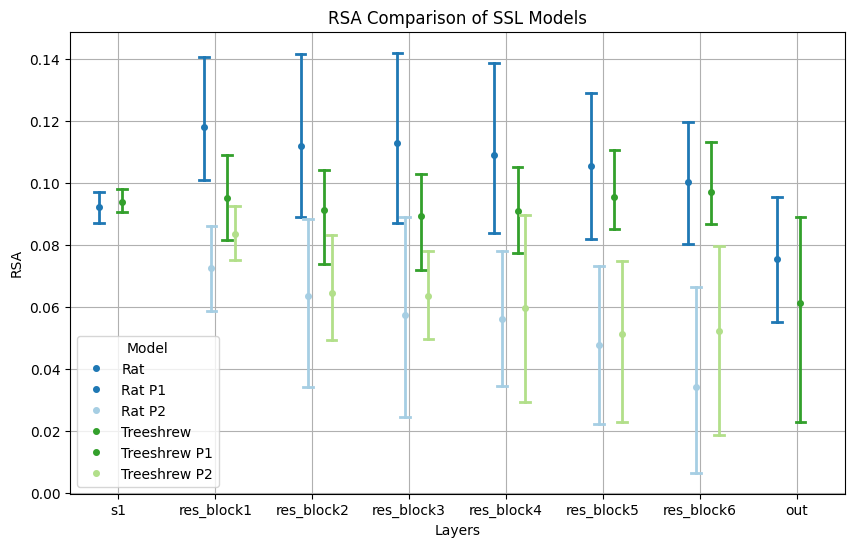

number of Cux2-CreERT2 experiment containers: 9



2024-06-18 00:58:15,939 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/660040138


experiment container: 658854535; num experiments: 1


2024-06-18 00:58:40,935 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722425


there are 91 neurons in this session


2024-06-18 00:58:53,873 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243526


experiment container: 511510645; num experiments: 1


2024-06-18 00:59:21,829 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721268


there are 84 neurons in this session


2024-06-18 00:59:34,515 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514532714


experiment container: 511510753; num experiments: 1


2024-06-18 00:59:59,974 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721236


there are 90 neurons in this session


2024-06-18 01:00:14,942 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516587367


experiment container: 511510817; num experiments: 1


2024-06-18 01:00:41,667 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721264


there are 83 neurons in this session


2024-06-18 01:00:53,527 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657656499


experiment container: 657470854; num experiments: 1


2024-06-18 01:01:14,613 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722387


there are 61 neurons in this session


2024-06-18 01:01:26,469 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516247313


experiment container: 511510822; num experiments: 1


2024-06-18 01:01:54,210 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721260


there are 128 neurons in this session


2024-06-18 01:02:11,145 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516244121


experiment container: 511510893; num experiments: 1


2024-06-18 01:02:37,977 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721300


there are 115 neurons in this session


2024-06-18 01:02:55,933 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514403115


experiment container: 511511083; num experiments: 1


2024-06-18 01:03:25,019 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721362


there are 100 neurons in this session


2024-06-18 01:03:41,793 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516251370


experiment container: 511976252; num experiments: 1


2024-06-18 01:04:02,973 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721387


there are 58 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



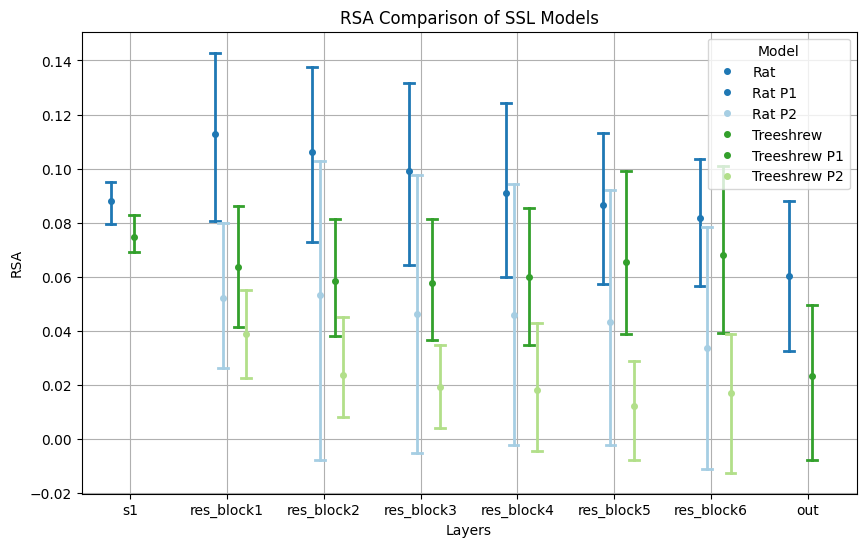

number of Cux2-CreERT2 experiment containers: 4



2024-06-18 01:05:06,550 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/717235679


experiment container: 716655272; num experiments: 1


2024-06-18 01:05:25,918 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722724


there are 65 neurons in this session


2024-06-18 01:05:35,319 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516238768


experiment container: 511510836; num experiments: 1


2024-06-18 01:06:22,223 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721286


there are 212 neurons in this session


2024-06-18 01:06:57,621 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516948535


experiment container: 511510940; num experiments: 1


2024-06-18 01:07:32,619 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721311


there are 142 neurons in this session


2024-06-18 01:07:52,996 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/664435651


experiment container: 658534530; num experiments: 1


2024-06-18 01:08:20,272 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722476


there are 103 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



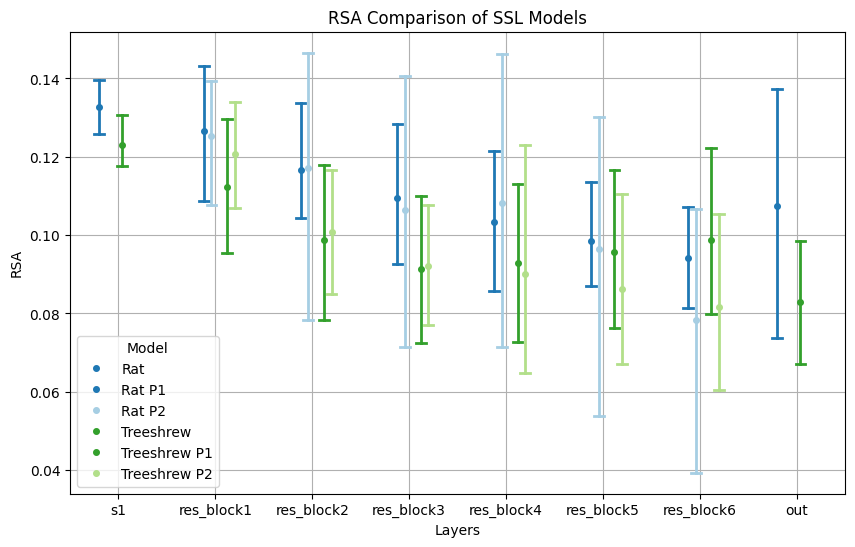

number of Cux2-CreERT2 experiment containers: 5



2024-06-18 01:09:27,595 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/707459036


experiment container: 701048110; num experiments: 1


2024-06-18 01:09:46,129 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722688


there are 47 neurons in this session


2024-06-18 01:09:56,010 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/570072232


experiment container: 569287964; num experiments: 1


2024-06-18 01:10:18,044 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721654


there are 18 neurons in this session


2024-06-18 01:10:22,921 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/571177249


experiment container: 570994450; num experiments: 1


2024-06-18 01:10:53,995 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721672


there are 110 neurons in this session


2024-06-18 01:11:10,999 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557509351


experiment container: 556899621; num experiments: 1


2024-06-18 01:11:31,006 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721523


there are 60 neurons in this session


2024-06-18 01:11:41,509 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569415083


experiment container: 565216521; num experiments: 1


2024-06-18 01:12:14,346 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721623


there are 150 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



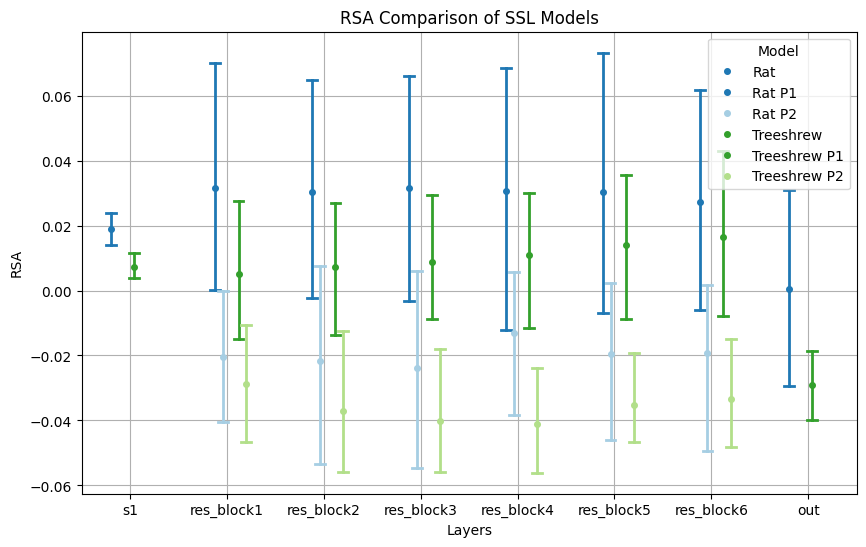

number of Cux2-CreERT2 experiment containers: 6



2024-06-18 01:13:35,096 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569955226


experiment container: 566759225; num experiments: 1


2024-06-18 01:14:13,788 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721632


there are 128 neurons in this session


2024-06-18 01:14:32,075 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/710015320


experiment container: 708949511; num experiments: 1


2024-06-18 01:14:46,409 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722694


there are 33 neurons in this session


2024-06-18 01:14:56,081 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/595037392


experiment container: 593902385; num experiments: 1


2024-06-18 01:15:15,436 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721889


there are 71 neurons in this session


2024-06-18 01:15:25,984 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/710959190


experiment container: 710469197; num experiments: 1


2024-06-18 01:15:51,051 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722704


there are 93 neurons in this session


2024-06-18 01:16:04,257 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/652784309


experiment container: 652094915; num experiments: 1


2024-06-18 01:16:40,429 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722317


there are 50 neurons in this session


2024-06-18 01:16:48,219 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569955234


experiment container: 566307034; num experiments: 1


2024-06-18 01:17:27,277 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721633


there are 159 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



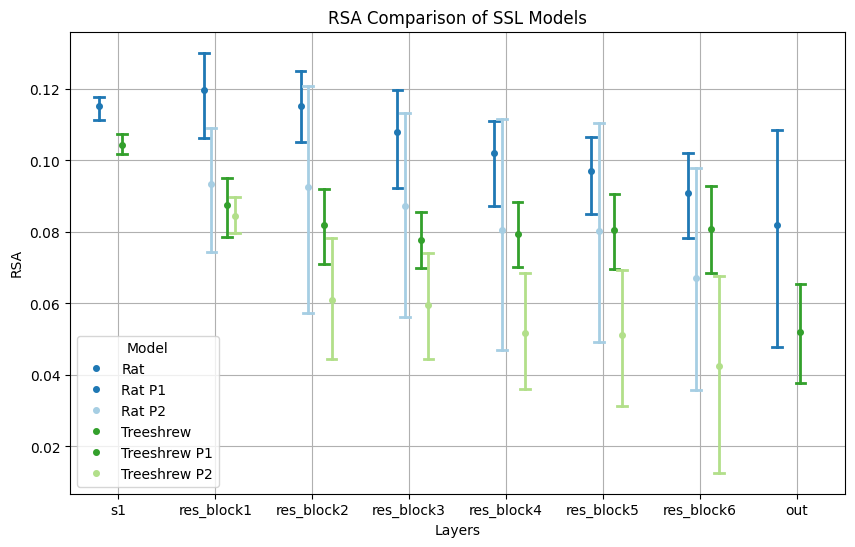

number of Cux2-CreERT2 experiment containers: 8

experiment container: 511510736; num experiments: 3
there are 174 neurons in this session


2024-06-18 01:18:48,324 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516244841
2024-06-18 01:19:35,904 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721214


there are 142 neurons in this session


2024-06-18 01:19:52,327 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514409327
2024-06-18 01:20:19,179 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721208


there are 108 neurons in this session
experiment container: 511510855; num experiments: 3
there are 242 neurons in this session


2024-06-18 01:20:29,884 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516803202
2024-06-18 01:21:56,370 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721353


there are 266 neurons in this session


2024-06-18 01:22:24,354 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516965622
2024-06-18 01:23:11,989 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721335


there are 284 neurons in this session
experiment container: 511509529; num experiments: 3
there are 214 neurons in this session


2024-06-18 01:23:37,390 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514409433
2024-06-18 01:24:13,465 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721207


there are 189 neurons in this session


2024-06-18 01:24:32,755 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514516625
2024-06-18 01:25:57,285 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721205


there are 215 neurons in this session
experiment container: 511507650; num experiments: 3
there are 152 neurons in this session


2024-06-18 01:26:23,880 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514407444
2024-06-18 01:26:57,458 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721200


there are 164 neurons in this session


2024-06-18 01:27:15,874 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514612445
2024-06-18 01:28:18,538 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721233


there are 205 neurons in this session


2024-06-18 01:28:43,850 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514393873


experiment container: 511510650; num experiments: 3


2024-06-18 01:29:41,312 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721221


there are 178 neurons in this session


2024-06-18 01:30:03,215 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514357717
2024-06-18 01:30:33,084 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721215


there are 109 neurons in this session
there are 163 neurons in this session
experiment container: 701412138; num experiments: 3
there are 120 neurons in this session


2024-06-18 01:30:45,015 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/704319451
2024-06-18 01:31:30,451 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722676


there are 95 neurons in this session


2024-06-18 01:31:43,435 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/705451291
2024-06-18 01:32:05,867 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722680


there are 99 neurons in this session
experiment container: 511510718; num experiments: 3
there are 331 neurons in this session


2024-06-18 01:32:20,539 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516617531
2024-06-18 01:32:55,583 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721346


there are 202 neurons in this session


2024-06-18 01:33:15,901 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516802485
2024-06-18 01:34:07,739 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/740369576


there are 226 neurons in this session


2024-06-18 01:34:29,480 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514557414


experiment container: 511510670; num experiments: 3


2024-06-18 01:35:46,307 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721235


there are 292 neurons in this session


2024-06-18 01:36:27,699 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516857381
2024-06-18 01:37:06,770 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721274


there are 208 neurons in this session
there are 295 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



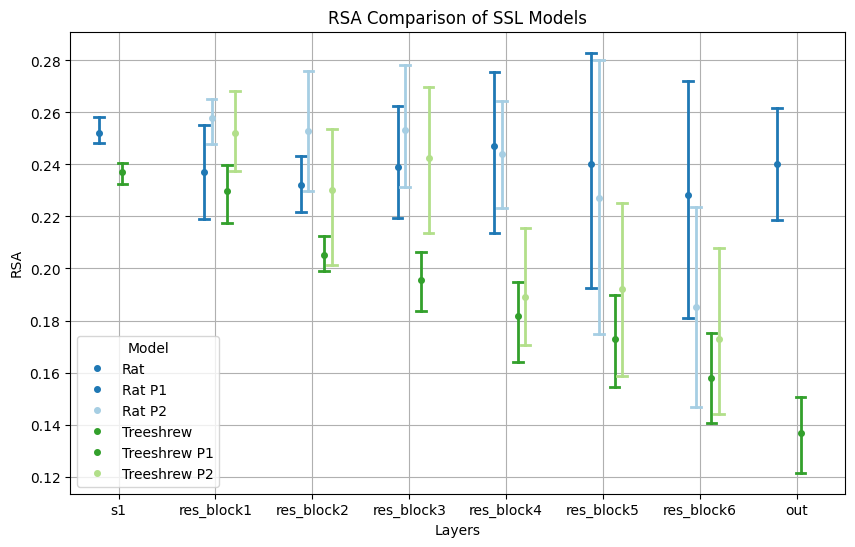

number of Cux2-CreERT2 experiment containers: 8



2024-06-18 01:38:15,574 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/702982915


experiment container: 702934962; num experiments: 3


2024-06-18 01:39:03,446 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722671


there are 140 neurons in this session


2024-06-18 01:39:23,309 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/703781774
2024-06-18 01:39:55,237 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722675


there are 122 neurons in this session
there are 118 neurons in this session


2024-06-18 01:40:11,633 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/645420810


experiment container: 645413757; num experiments: 3


2024-06-18 01:41:19,310 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722234


there are 226 neurons in this session


2024-06-18 01:41:40,449 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/648176162
2024-06-18 01:42:23,454 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722250


there are 191 neurons in this session
there are 206 neurons in this session
experiment container: 659767480; num experiments: 3
there are 143 neurons in this session


2024-06-18 01:43:02,456 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/659783801
2024-06-18 01:43:46,072 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722426


there are 148 neurons in this session


2024-06-18 01:44:04,409 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/660522208
2024-06-18 01:45:04,723 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722437


there are 198 neurons in this session


2024-06-18 01:45:27,866 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/714797491


experiment container: 712178509; num experiments: 3


2024-06-18 01:46:10,785 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722719


there are 214 neurons in this session
there are 159 neurons in this session


2024-06-18 01:46:34,844 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/712189321
2024-06-18 01:47:44,140 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722710


there are 200 neurons in this session


2024-06-18 01:48:03,386 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514424422


experiment container: 511510667; num experiments: 3


2024-06-18 01:48:36,650 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721217


there are 210 neurons in this session
there are 212 neurons in this session


2024-06-18 01:48:57,609 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514424623
2024-06-18 01:50:08,991 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721213


there are 240 neurons in this session


2024-06-18 01:50:30,707 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/526532746


experiment container: 524691282; num experiments: 3


2024-06-18 01:51:27,570 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721396


there are 271 neurons in this session
there are 249 neurons in this session


2024-06-18 01:51:49,245 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/525695690
2024-06-18 01:52:54,406 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721394


there are 264 neurons in this session


2024-06-18 01:53:26,534 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516248508


experiment container: 511510699; num experiments: 3


2024-06-18 01:54:08,825 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721253


there are 240 neurons in this session
there are 287 neurons in this session


2024-06-18 01:54:37,114 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514828699
2024-06-18 01:56:06,980 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721244


there are 318 neurons in this session


2024-06-18 01:56:41,686 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516334450


experiment container: 511510779; num experiments: 3


2024-06-18 01:57:51,757 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721245


there are 379 neurons in this session


2024-06-18 01:58:24,724 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516802840
2024-06-18 01:59:41,766 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721255


there are 353 neurons in this session
there are 359 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



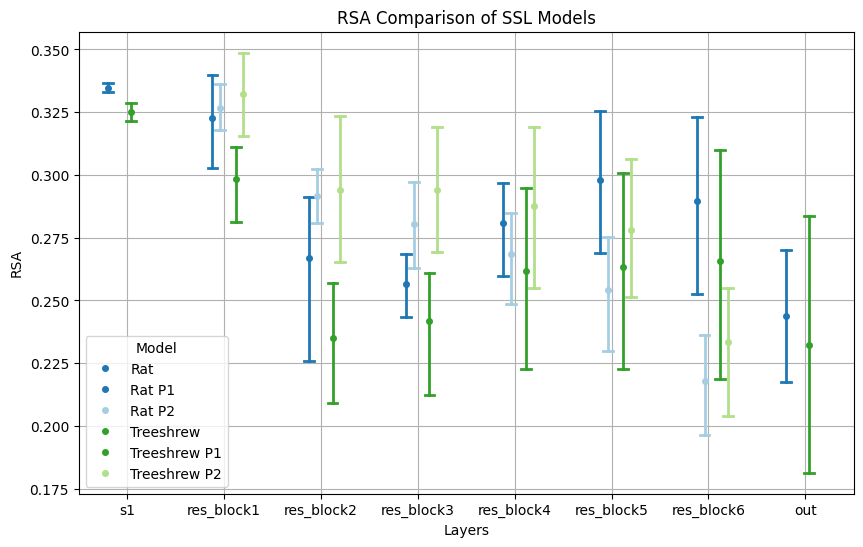

number of Cux2-CreERT2 experiment containers: 6



2024-06-18 02:00:55,332 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516667502


experiment container: 511510994; num experiments: 3


2024-06-18 02:01:43,731 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721290


there are 117 neurons in this session


2024-06-18 02:02:00,587 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243950
2024-06-18 02:02:33,130 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721297


there are 91 neurons in this session
there are 99 neurons in this session
experiment container: 647595663; num experiments: 3
there are 114 neurons in this session


2024-06-18 02:02:42,135 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/650074083
2024-06-18 02:03:10,618 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722274


there are 122 neurons in this session


2024-06-18 02:03:27,071 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/648610907
2024-06-18 02:04:15,773 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722255


there are 108 neurons in this session
experiment container: 511510917; num experiments: 3
there are 176 neurons in this session


2024-06-18 02:04:28,145 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516244336
2024-06-18 02:04:59,321 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721294


there are 184 neurons in this session


2024-06-18 02:05:20,391 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516856106
2024-06-18 02:06:09,488 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721307


there are 188 neurons in this session


2024-06-18 02:06:26,661 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514340576


experiment container: 511510688; num experiments: 3


2024-06-18 02:07:13,541 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721231


there are 143 neurons in this session
there are 137 neurons in this session


2024-06-18 02:07:37,077 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514398192
2024-06-18 02:08:06,509 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721241


there are 146 neurons in this session


2024-06-18 02:08:31,197 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516793475


experiment container: 511510640; num experiments: 3


2024-06-18 02:09:16,320 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721250


there are 153 neurons in this session


2024-06-18 02:09:29,545 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514614030
2024-06-18 02:09:58,206 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721237


there are 166 neurons in this session
there are 175 neurons in this session


2024-06-18 02:10:12,201 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/552417877


experiment container: 551657958; num experiments: 3


2024-06-18 02:10:45,968 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721478


there are 108 neurons in this session


2024-06-18 02:11:01,301 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/552747738
2024-06-18 02:11:41,745 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721484


there are 85 neurons in this session
there are 74 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



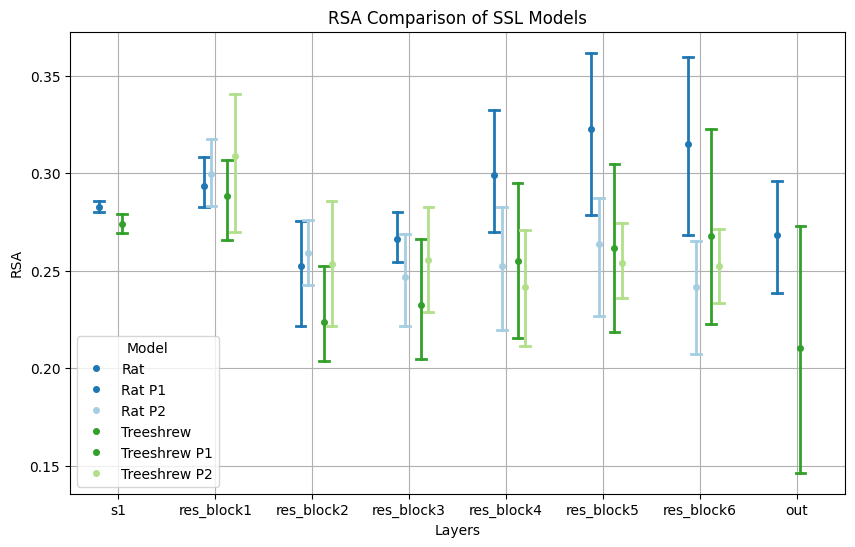

number of Cux2-CreERT2 experiment containers: 5



2024-06-18 02:12:32,119 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/701075278


experiment container: 699155263; num experiments: 3


2024-06-18 02:12:59,026 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722667


there are 128 neurons in this session


2024-06-18 02:13:15,138 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/699170374
2024-06-18 02:13:57,861 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722664


there are 109 neurons in this session
there are 125 neurons in this session
experiment container: 511510870; num experiments: 3
there are 257 neurons in this session


2024-06-18 02:14:10,868 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516251233
2024-06-18 02:14:51,455 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721370


there are 217 neurons in this session


2024-06-18 02:15:10,192 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516245589
2024-06-18 02:16:26,424 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721341


there are 256 neurons in this session


2024-06-18 02:16:59,310 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/530990671


experiment container: 529487170; num experiments: 3


2024-06-18 02:17:51,070 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721413


there are 115 neurons in this session
there are 147 neurons in this session


2024-06-18 02:18:10,177 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/530482065
2024-06-18 02:18:38,536 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721417


there are 140 neurons in this session


2024-06-18 02:18:53,824 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516244400


experiment container: 511510848; num experiments: 3


2024-06-18 02:20:13,856 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721308


there are 293 neurons in this session
there are 297 neurons in this session


2024-06-18 02:20:44,285 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516948015
2024-06-18 02:21:32,810 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721276


there are 254 neurons in this session


2024-06-18 02:22:01,151 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516244280


experiment container: 511510945; num experiments: 3


2024-06-18 02:22:38,670 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721314


there are 212 neurons in this session


2024-06-18 02:22:56,833 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516974810
2024-06-18 02:23:57,865 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721321


there are 253 neurons in this session
there are 243 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



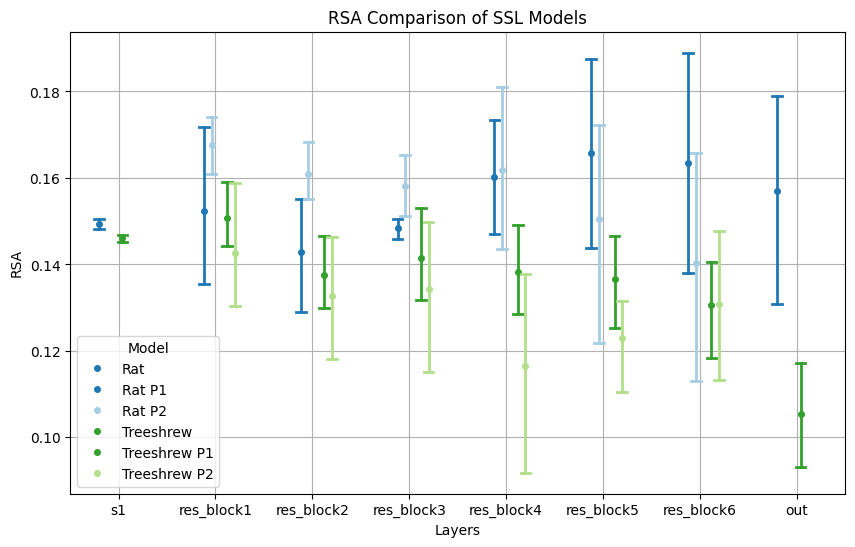

number of Cux2-CreERT2 experiment containers: 6



2024-06-18 02:25:12,189 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516802565


experiment container: 511510715; num experiments: 3


2024-06-18 02:25:47,912 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721222


there are 165 neurons in this session


2024-06-18 02:26:03,910 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514432466
2024-06-18 02:26:48,357 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721224


there are 181 neurons in this session
there are 172 neurons in this session


2024-06-18 02:27:10,549 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516617715


experiment container: 511510998; num experiments: 3


2024-06-18 02:27:35,870 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721299


there are 86 neurons in this session


2024-06-18 02:27:48,162 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516793111
2024-06-18 02:28:30,939 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/740369575


there are 76 neurons in this session
there are 89 neurons in this session
experiment container: 511510797; num experiments: 3
there are 164 neurons in this session


2024-06-18 02:28:41,385 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514433445
2024-06-18 02:29:28,977 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721223


there are 198 neurons in this session


2024-06-18 02:29:46,937 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514555904
2024-06-18 02:30:40,165 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721230


there are 217 neurons in this session


2024-06-18 02:31:01,454 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514370248


experiment container: 511510695; num experiments: 3


2024-06-18 02:31:46,213 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721257


there are 119 neurons in this session
there are 89 neurons in this session


2024-06-18 02:31:55,579 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514383490
2024-06-18 02:32:26,789 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721266


there are 98 neurons in this session
experiment container: 555700037; num experiments: 3
there are 78 neurons in this session


2024-06-18 02:32:39,197 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557532958
2024-06-18 02:33:09,207 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721524


there are 47 neurons in this session


2024-06-18 02:33:18,500 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557707440
2024-06-18 02:33:41,782 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721528


there are 38 neurons in this session


2024-06-18 02:33:48,700 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514546973


experiment container: 511510664; num experiments: 3


2024-06-18 02:34:32,667 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721234


there are 159 neurons in this session
there are 161 neurons in this session


2024-06-18 02:34:57,546 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516803539
2024-06-18 02:35:32,447 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721248


there are 157 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



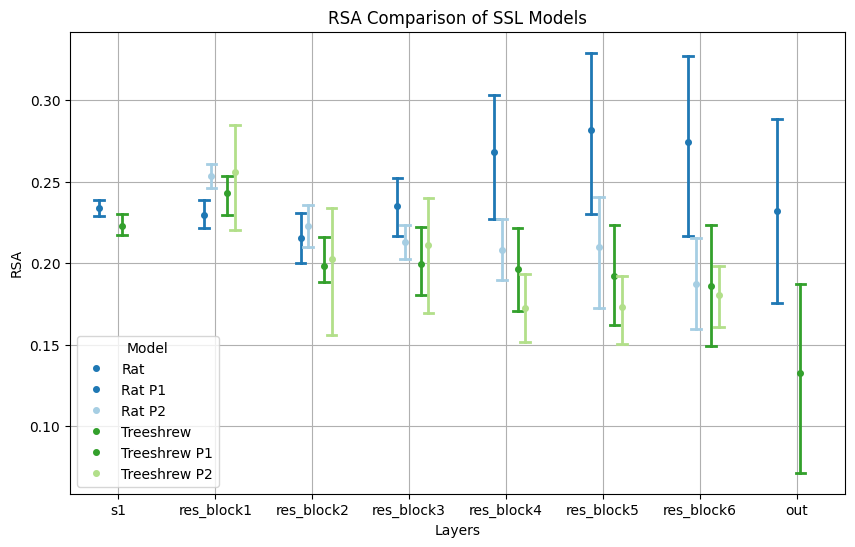

number of Cux2-CreERT2 experiment containers: 6



2024-06-18 02:36:30,843 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/517023824


experiment container: 511854338; num experiments: 3


2024-06-18 02:37:49,426 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721393


there are 240 neurons in this session
there are 169 neurons in this session


2024-06-18 02:38:16,436 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516803753
2024-06-18 02:38:53,501 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721385


there are 165 neurons in this session


2024-06-18 02:39:08,897 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516944072


experiment container: 511510867; num experiments: 3


2024-06-18 02:40:10,558 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721282


there are 202 neurons in this session
there are 155 neurons in this session


2024-06-18 02:40:30,985 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243810
2024-06-18 02:41:09,456 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721278


there are 163 neurons in this session
experiment container: 511511052; num experiments: 3
there are 171 neurons in this session


2024-06-18 02:41:26,515 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516244435
2024-06-18 02:41:59,305 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721323


there are 151 neurons in this session


2024-06-18 02:42:19,261 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516965667
2024-06-18 02:43:16,352 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721313


there are 207 neurons in this session


2024-06-18 02:43:44,164 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/559002856


experiment container: 556936291; num experiments: 3


2024-06-18 02:44:34,629 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721547


there are 168 neurons in this session


2024-06-18 02:44:50,336 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557185146
2024-06-18 02:45:39,710 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721519


there are 154 neurons in this session
there are 173 neurons in this session


2024-06-18 02:46:01,881 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516368865


experiment container: 511856567; num experiments: 3


2024-06-18 02:47:16,834 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721389


there are 286 neurons in this session


2024-06-18 02:47:55,478 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516273634
2024-06-18 02:48:35,474 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721382


there are 206 neurons in this session
there are 195 neurons in this session
experiment container: 638056632; num experiments: 3
there are 146 neurons in this session


2024-06-18 02:48:58,552 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/637377197
2024-06-18 02:49:34,436 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722147


there are 146 neurons in this session


2024-06-18 02:49:55,030 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/630146623
2024-06-18 02:50:39,828 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722128


there are 162 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



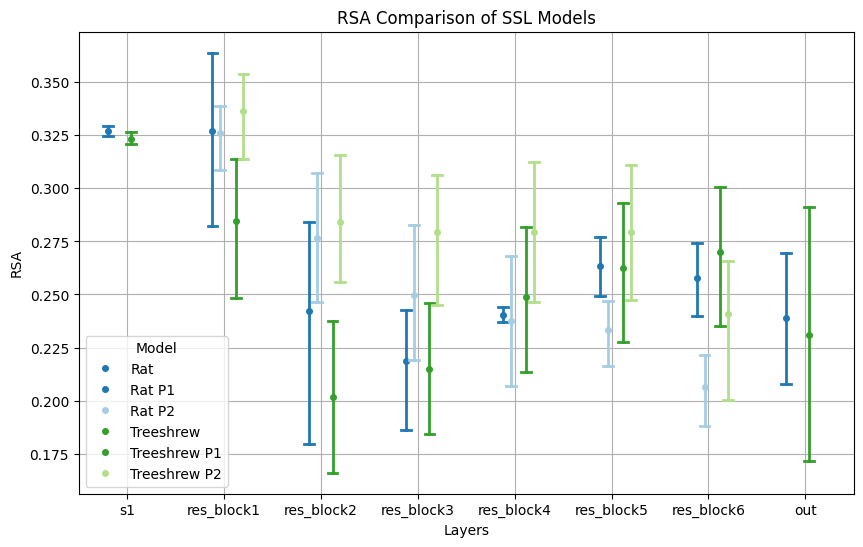

number of Cux2-CreERT2 experiment containers: 9



2024-06-18 02:51:39,611 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/661802275


experiment container: 658854535; num experiments: 3


2024-06-18 02:52:00,963 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722445


there are 84 neurons in this session
there are 91 neurons in this session


2024-06-18 02:52:15,821 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/659164893
2024-06-18 02:53:01,122 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722418


there are 112 neurons in this session


2024-06-18 02:53:12,479 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514802365


experiment container: 511510645; num experiments: 3


2024-06-18 02:53:54,343 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721247


there are 90 neurons in this session


2024-06-18 02:54:03,424 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516802407
2024-06-18 02:54:28,474 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721263


there are 74 neurons in this session
there are 84 neurons in this session


2024-06-18 02:54:40,789 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514432788


experiment container: 511510753; num experiments: 3


2024-06-18 02:55:01,274 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721232


there are 82 neurons in this session
there are 90 neurons in this session


2024-06-18 02:55:11,823 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514609062
2024-06-18 02:56:02,600 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721239


there are 106 neurons in this session
experiment container: 511510817; num experiments: 3
there are 83 neurons in this session


2024-06-18 02:56:21,425 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243551
2024-06-18 02:57:02,238 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721267


there are 94 neurons in this session


2024-06-18 02:57:15,184 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516244422
2024-06-18 02:57:35,130 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721258


there are 84 neurons in this session


2024-06-18 02:57:47,203 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657475130


experiment container: 657470854; num experiments: 3


2024-06-18 02:58:19,182 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722380


there are 59 neurons in this session


2024-06-18 02:58:28,342 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657917031
2024-06-18 02:59:13,099 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722397


there are 84 neurons in this session
there are 61 neurons in this session
experiment container: 511510822; num experiments: 3
there are 128 neurons in this session


2024-06-18 02:59:22,711 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516243460
2024-06-18 02:59:55,081 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721265


there are 142 neurons in this session


2024-06-18 03:00:08,655 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516246339
2024-06-18 03:01:05,709 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721256


there are 167 neurons in this session


2024-06-18 03:01:25,330 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516617514


experiment container: 511510893; num experiments: 3


2024-06-18 03:01:51,266 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721292


there are 90 neurons in this session
there are 115 neurons in this session


2024-06-18 03:02:00,299 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516608604
2024-06-18 03:02:38,826 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721306


there are 101 neurons in this session


2024-06-18 03:02:53,226 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514401564


experiment container: 511511083; num experiments: 3


2024-06-18 03:03:16,829 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721357


there are 102 neurons in this session
there are 100 neurons in this session


2024-06-18 03:03:27,323 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514360791
2024-06-18 03:04:17,271 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721368


there are 124 neurons in this session
experiment container: 511976252; num experiments: 3
there are 58 neurons in this session


2024-06-18 03:04:33,901 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516803768
2024-06-18 03:05:16,434 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721392


there are 70 neurons in this session


2024-06-18 03:05:29,922 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516249565
2024-06-18 03:05:49,477 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721383


there are 45 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



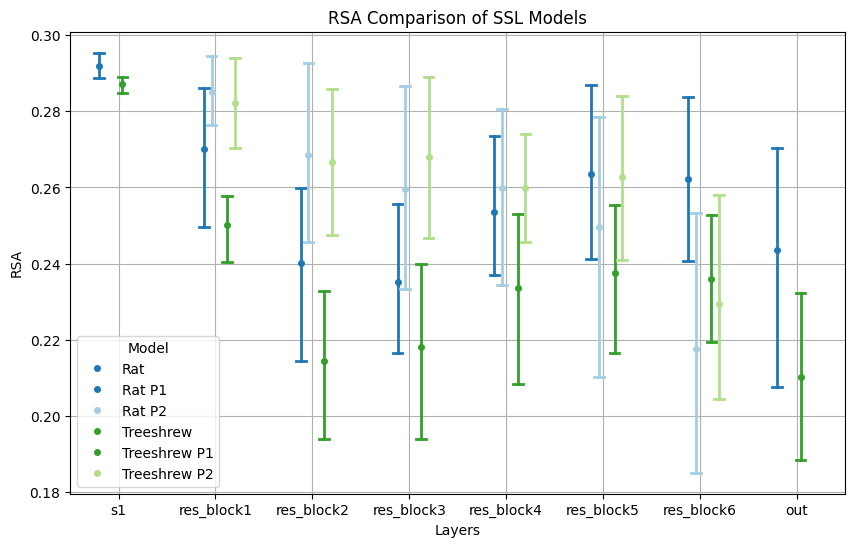

number of Cux2-CreERT2 experiment containers: 4

experiment container: 716655272; num experiments: 3
there are 65 neurons in this session


2024-06-18 03:06:39,328 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/717101694
2024-06-18 03:07:20,188 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722723


there are 85 neurons in this session


2024-06-18 03:07:28,408 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/718350069
2024-06-18 03:07:49,761 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722725


there are 74 neurons in this session


2024-06-18 03:07:59,342 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516238128


experiment container: 511510836; num experiments: 3


2024-06-18 03:08:54,448 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721284


there are 252 neurons in this session


2024-06-18 03:09:17,582 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516238751
2024-06-18 03:10:18,968 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721289


there are 232 neurons in this session
there are 212 neurons in this session
experiment container: 511510940; num experiments: 3
there are 142 neurons in this session


2024-06-18 03:10:44,080 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516666429
2024-06-18 03:11:19,207 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721309


there are 139 neurons in this session


2024-06-18 03:11:32,552 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516967922
2024-06-18 03:12:54,829 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721315


there are 231 neurons in this session
experiment container: 658534530; num experiments: 3
there are 103 neurons in this session


2024-06-18 03:13:21,284 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/664905383
2024-06-18 03:13:51,589 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722480


there are 72 neurons in this session


2024-06-18 03:14:00,104 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/663881086
2024-06-18 03:14:51,926 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/740369591


there are 128 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



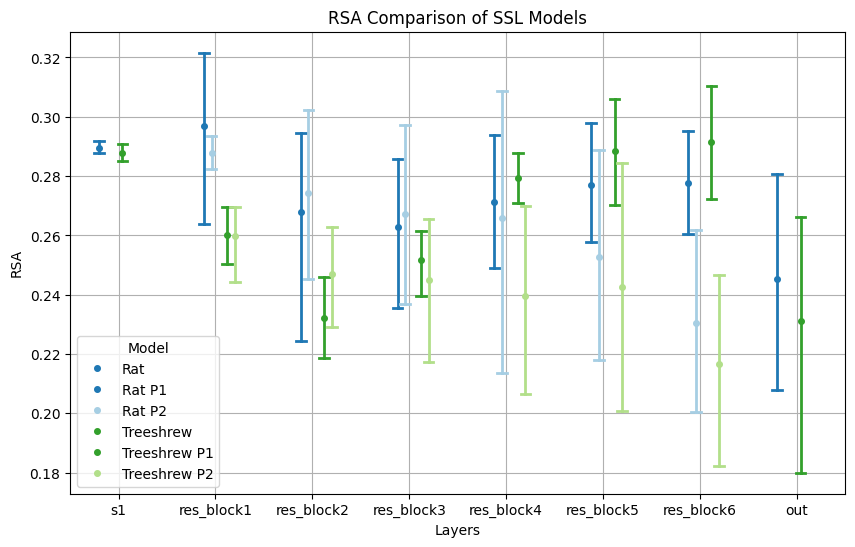

number of Cux2-CreERT2 experiment containers: 5



2024-06-18 03:15:50,275 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/707039334


experiment container: 701048110; num experiments: 3


2024-06-18 03:16:32,723 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722685


there are 35 neurons in this session
there are 47 neurons in this session


2024-06-18 03:16:40,739 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/707973363
2024-06-18 03:16:59,703 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722692


there are 47 neurons in this session


2024-06-18 03:17:08,800 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569978085


experiment container: 569287964; num experiments: 3
there are 18 neurons in this session


2024-06-18 03:17:23,059 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/740369579
2024-06-18 03:17:28,337 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569768154


there are 24 neurons in this session


2024-06-18 03:17:58,195 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721645


there are 42 neurons in this session


2024-06-18 03:18:04,863 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/571101372


experiment container: 570994450; num experiments: 3


2024-06-18 03:18:46,248 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721669


there are 113 neurons in this session


2024-06-18 03:19:01,183 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/571180941
2024-06-18 03:19:41,697 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721675


there are 88 neurons in this session
there are 110 neurons in this session
experiment container: 556899621; num experiments: 3
there are 60 neurons in this session


2024-06-18 03:19:52,720 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/558682951
2024-06-18 03:20:13,808 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721540


there are 73 neurons in this session


2024-06-18 03:20:24,009 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/557798231
2024-06-18 03:20:59,534 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721526


there are 79 neurons in this session
experiment container: 565216521; num experiments: 3
there are 150 neurons in this session


2024-06-18 03:21:10,657 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/565774619
2024-06-18 03:21:40,640 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721605


there are 97 neurons in this session


2024-06-18 03:21:53,770 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/565457212
2024-06-18 03:22:48,072 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721603


there are 118 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



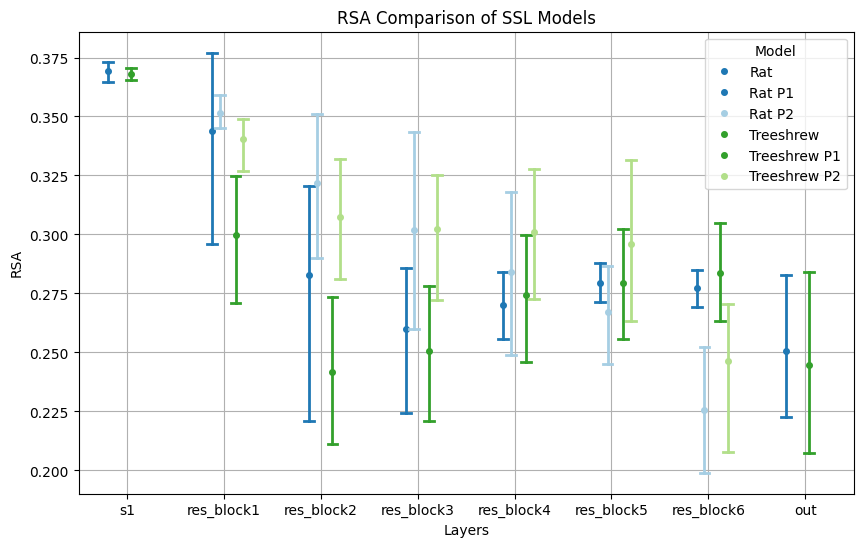

number of Cux2-CreERT2 experiment containers: 6



2024-06-18 03:23:50,942 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/569644170


experiment container: 566759225; num experiments: 3


2024-06-18 03:24:27,580 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721638


there are 126 neurons in this session
there are 128 neurons in this session


2024-06-18 03:24:47,035 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/570361800
2024-06-18 03:25:52,177 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721663


there are 181 neurons in this session
experiment container: 708949511; num experiments: 3
there are 33 neurons in this session


2024-06-18 03:26:09,386 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/710959270
2024-06-18 03:26:26,699 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722703
2024-06-18 03:26:30,709 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/712937196


there are 17 neurons in this session


2024-06-18 03:26:56,879 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722711


there are 22 neurons in this session
experiment container: 593902385; num experiments: 3
there are 71 neurons in this session


2024-06-18 03:27:03,016 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/595449904
2024-06-18 03:27:36,783 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/740369583


there are 82 neurons in this session


2024-06-18 03:27:46,354 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/594684767
2024-06-18 03:28:10,754 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721886


there are 89 neurons in this session


2024-06-18 03:28:24,374 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/711632781


experiment container: 710469197; num experiments: 3


2024-06-18 03:28:52,608 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722707


there are 111 neurons in this session
there are 93 neurons in this session


2024-06-18 03:29:08,649 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/710521723
2024-06-18 03:29:54,536 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722696


there are 112 neurons in this session


2024-06-18 03:30:08,857 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/653336839


experiment container: 652094915; num experiments: 3


2024-06-18 03:30:28,898 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722345


there are 35 neurons in this session
there are 50 neurons in this session


2024-06-18 03:30:35,358 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/652319355
2024-06-18 03:31:17,979 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739722304


there are 62 neurons in this session


2024-06-18 03:31:27,764 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/566750976


experiment container: 566307034; num experiments: 3


2024-06-18 03:32:02,339 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721611


there are 139 neurons in this session


2024-06-18 03:32:22,708 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/566583306
2024-06-18 03:33:29,764 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721609


there are 239 neurons in this session
there are 159 neurons in this session
Calculating RDMs for ../models/rat1.ckpt
Calculating RDMs for ../models/rat2.ckpt
Calculating RDMs for ../models/rat3.ckpt
Calculating RDMs for ../models/rat4.ckpt
Calculating RDMs for ../models/rat5.ckpt
Calculating RSA for Rat
Done

Calculating RDMs for ../models/ts1.ckpt
Calculating RDMs for ../models/ts2.ckpt
Calculating RDMs for ../models/ts3.ckpt
Calculating RDMs for ../models/ts4.ckpt
Calculating RDMs for ../models/ts5.ckpt
Calculating RSA for Treeshrew
Done



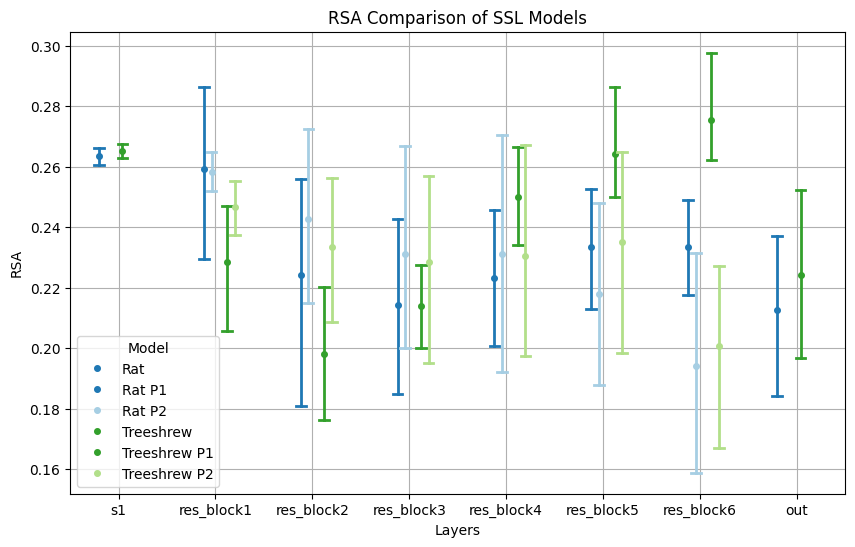

In [3]:
areas = [(area, depth, cre_line) for area in ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam'] for depth in [175, 275] for cre_line in ['Cux2-CreERT2']]     
num_iter = 100
models = {
    'Rat': sorted(glob.glob("../models/rat*.ckpt")),
    'Treeshrew': sorted(glob.glob("../models/ts*.ckpt"))
}

for stim_type in ['natural_scenes', 'natural_movie_one']:
    compare_rsa(models=models, areas=areas, stim_type=stim_type, num_iter=num_iter, subsample=15, fig_path='../results')